In [71]:
from IPython.display import Image
#Image(filename='ANTI-INFECTIVES-RGB_200pc.png')

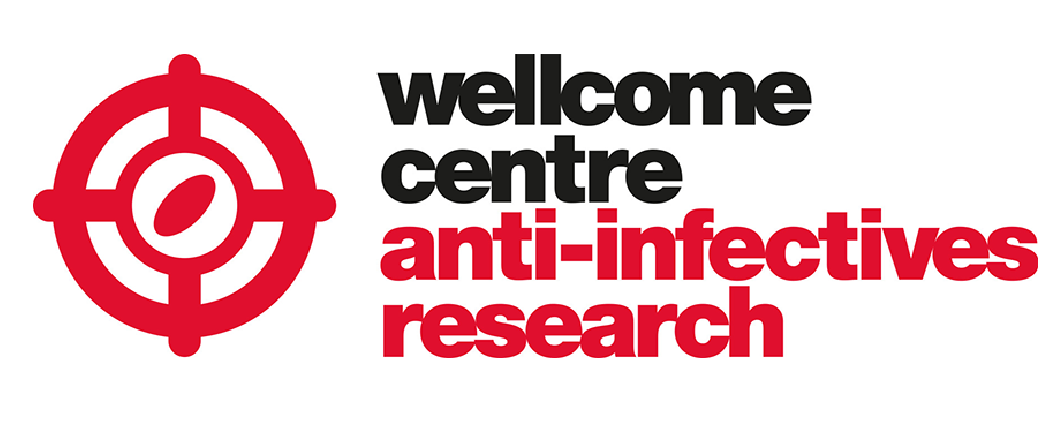

In [73]:
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread('ANTI-INFECTIVES-RGB_200pc.png')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()


# Analysis of Senescent Proteins in Human

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee


## Aims
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane.

In [110]:
%matplotlib inline

In [111]:
import sys
print(sys.version)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]


In [112]:
#iteresting ref for tmt/ibaq data normalization
#https://pwilmart.github.io/IRS_normalization/understanding_IRS.html

#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import missingno as msno
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [113]:
#define helping function
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text

def make_scatter_matrix(in_df):
    sns.set(font_scale = 1)
    #sns.set(style="white")
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.3f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    
    g = sns.PairGrid(in_df, palette=["red"]) 
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False) 
    g.map_lower(sns.kdeplot, cmap="Blues_d") 
    g.map_lower(corrfunc)
    plt.show()


def make_pca(in_df, palette, top=500):
    cols = in_df.columns
    pca = PCA(n_components=2)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('PCA',size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    plt.show()
    
def make_mds(in_df, palette, top=500):
    cols = in_df.columns
    pca = MDS(n_components=2,metric=True)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols,columns =['pc_1','pc_2'] )
    
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)

    plt.show()


## Sanity Check
### Raw files
We analyse the 20 raw files that compose our dataset. Each raw files is the analysis of one fractionated sample. 

### TMT channels intesity

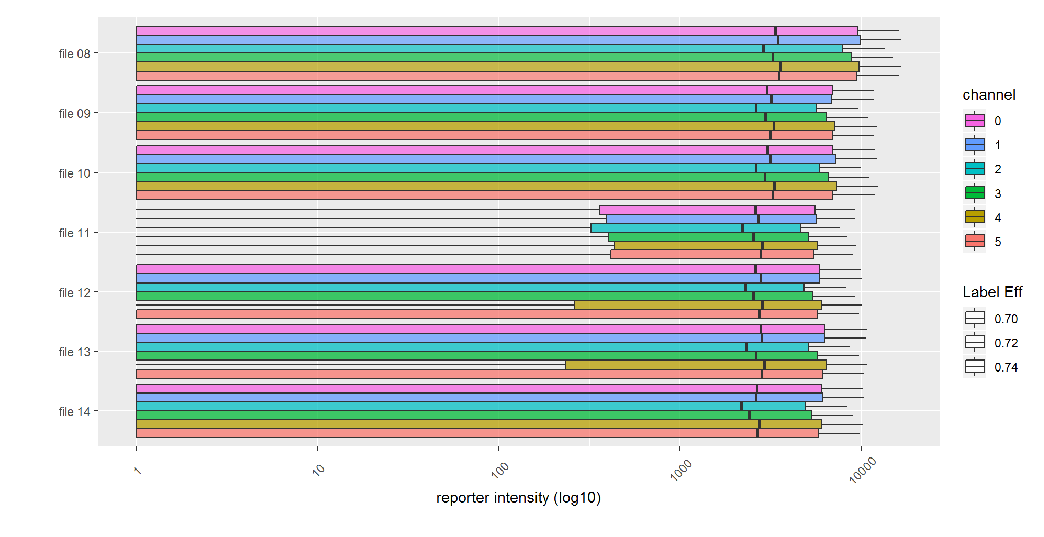

In [114]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread('sanityc/metrics-6.png')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='sanityc/metrics-6.png') 

This picture show that most of the raw files have small intensity values for the TMT channels. Also, the average intensity is a log smaller that the usal intensity we have observed with other TMT experiments. All the plot shuld be looking like the file 12 but with higher mean.

### Column retention time


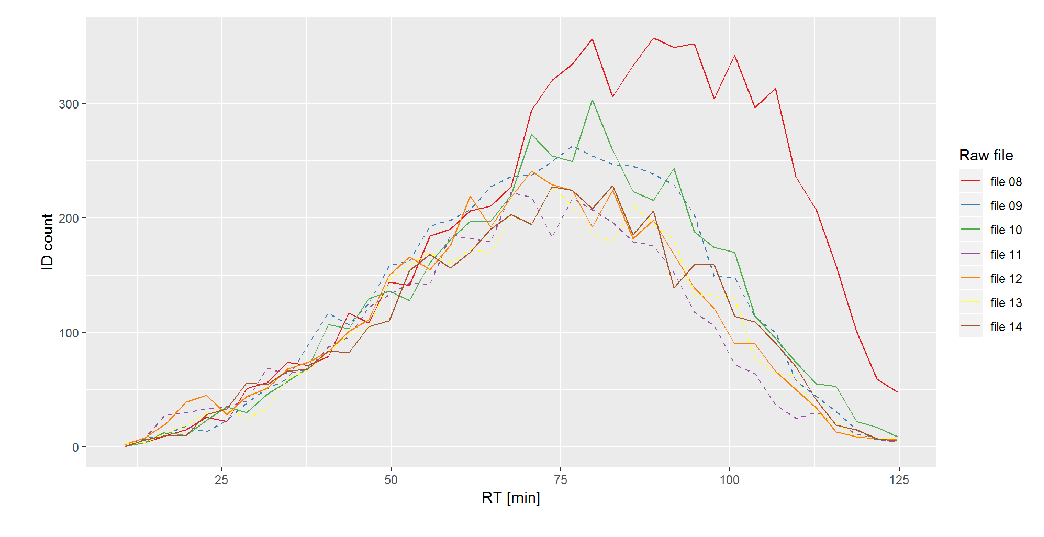

In [115]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread('sanityc/metrics-19.png')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='sanityc/metrics-19.png') 

This picture show that we reach the maximum amount of identifications quite late during the gradient. In other TMT experiments we observed the identification reaching their maximumjust after 25 minutes.

## Label efficency
the raw file: PS-TMT-Frac-2 was serched using mascot ant TMT 6plex as variable modifications. we ask the percentage of TMT modified peptides over the total.

In [150]:
def count_lines(infile):
    for index, l in enumerate(open(infile)):
        if l.startswith('prot_hit_num'):
            return index
        
start_line = count_lines('F260579.csv')
temp = pd.read_csv('F260579.csv',skiprows=start_line)

In [151]:
print(temp['pep_var_mod'].shape)
a=0
for n in temp['pep_var_mod']:
    #print(n)
    if 'TMT6' in str(n):
        a+=1
print(a/temp.shape[0]*100)

(26830,)
70.65225493850168


I think is too low....

## Dataset analysis

In [156]:
#load the dataset
df = pd.read_table(os.path.join('97_2019_IMS-MRC_JG-MaxQuant results', 'txt', 'proteinGroups.txt'))
df.head()
#print(df.shape)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
#print(list(df.columns))
cols = ['Reporter intensity corrected {} PS-TMT'.format(n) for n in range(0,6)]
data=df[cols]
data.columns = ['S1','S2','S3', 'C1','C2','C3']

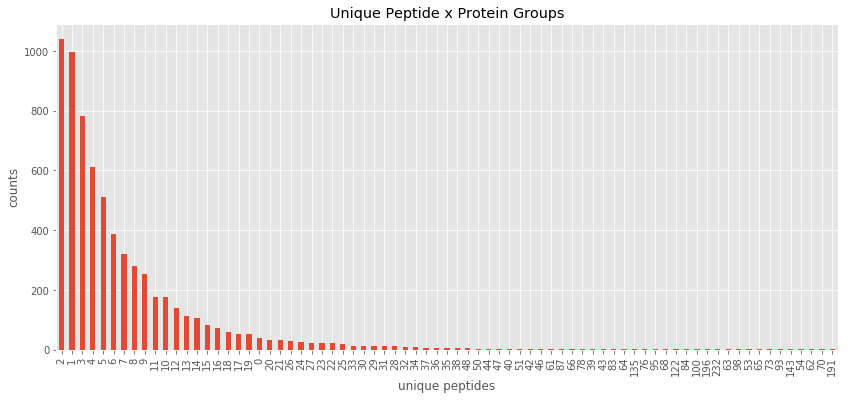

In [163]:
fig,ax=plt.subplots(figsize=(14,6))
df['Unique peptides'].value_counts().plot(kind='bar',ax=ax)
plt.title('Unique Peptide x Protein Groups')
ax.set_xlabel('unique peptides')
ax.set_ylabel('counts')
plt.show()

We can see many protein groups identified with just one unique peptide, not good.

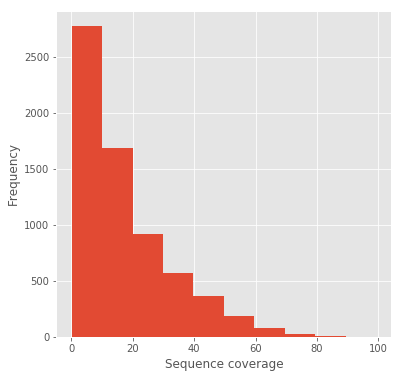

In [174]:
fig,ax=plt.subplots(figsize=(6,6))
df['Sequence coverage [%]'].plot(kind='hist',ax=ax)
ax.set_xlabel('Sequence coverage')
plt.show()

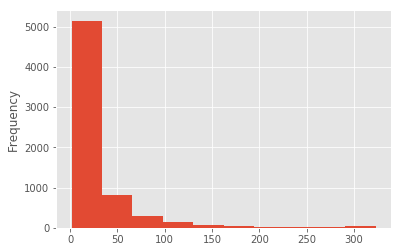

In [173]:
df['Score'].plot(kind='hist')
ax.set_xlabel('Score')
plt.show()

### Missing Data Analysis

(6614, 6)


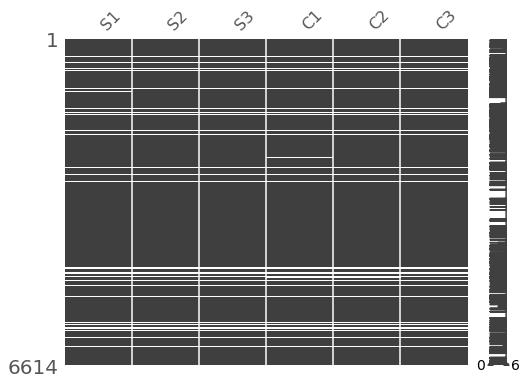

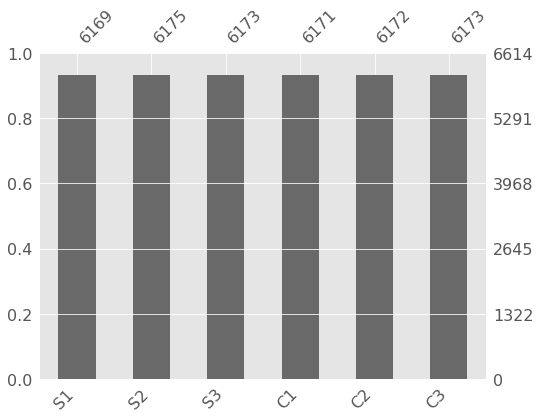

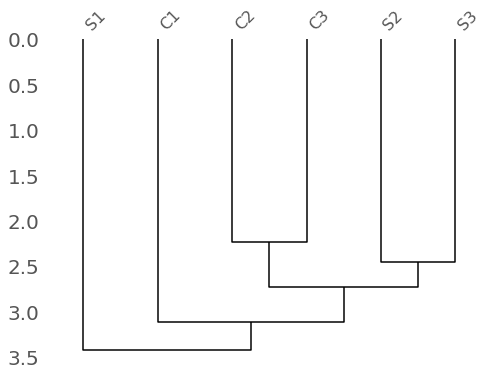

(6614, 6)


In [184]:
print(data.shape)
data=data.replace(0, np.nan)
msno.matrix(data, figsize=(8, 6))
#plt.title('Missing Data')
plt.show()

msno.bar(data, figsize=(8, 6))
plt.show()

msno.dendrogram(data, figsize=(8, 6))
plt.show()

data=data.replace(np.nan,0)
data = data.dropna(how='all')
print(data.shape)

This picture show that we identified an 6614 protein groups. For the moment we do not use any filter for the number of unique peptides

In [121]:
#how many protein group with two unique peptides?
df[df['Unique peptides']>=2].shape

(5577, 100)

### Average Intensity

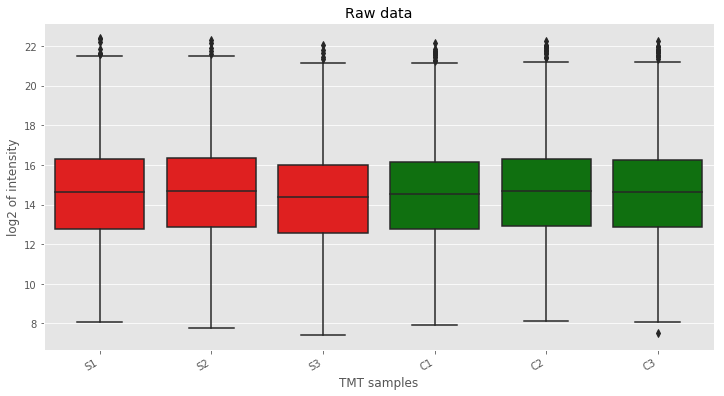

In [8]:
my_pal = ["r"]*3+["g"]*3
fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Raw data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()

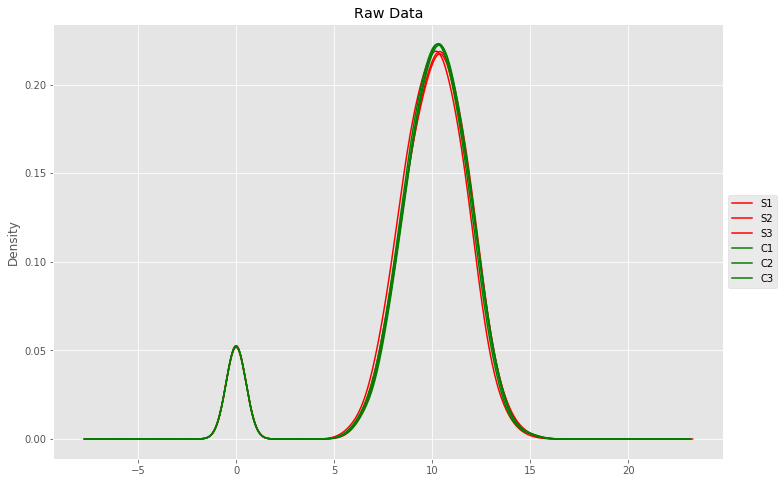

In [9]:
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw Data')
plt.show()

Tee pictures above show a very good distribution of the TMT channel intensity for bot senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### PCA analysis


[0.9372617  0.05767395]


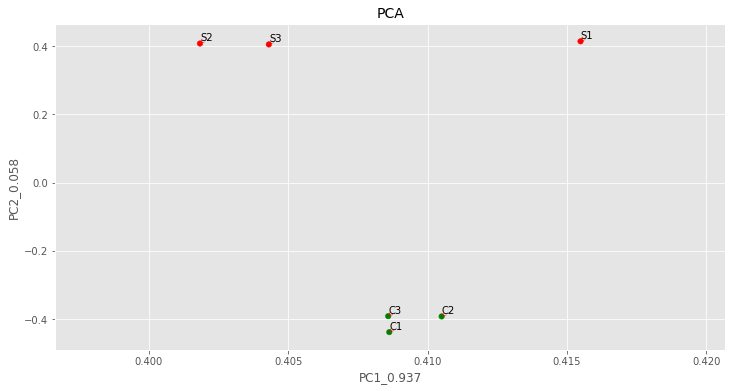

In [10]:
make_pca(np.log2(data), my_pal)

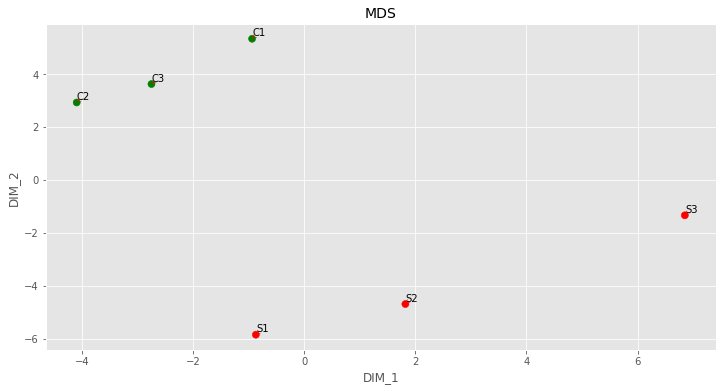

In [11]:
make_mds(np.log2(data), my_pal)

With two dimensinality reduction tecniques (PCA and MDS) we observe a good separation of senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### Reproducibility analysis

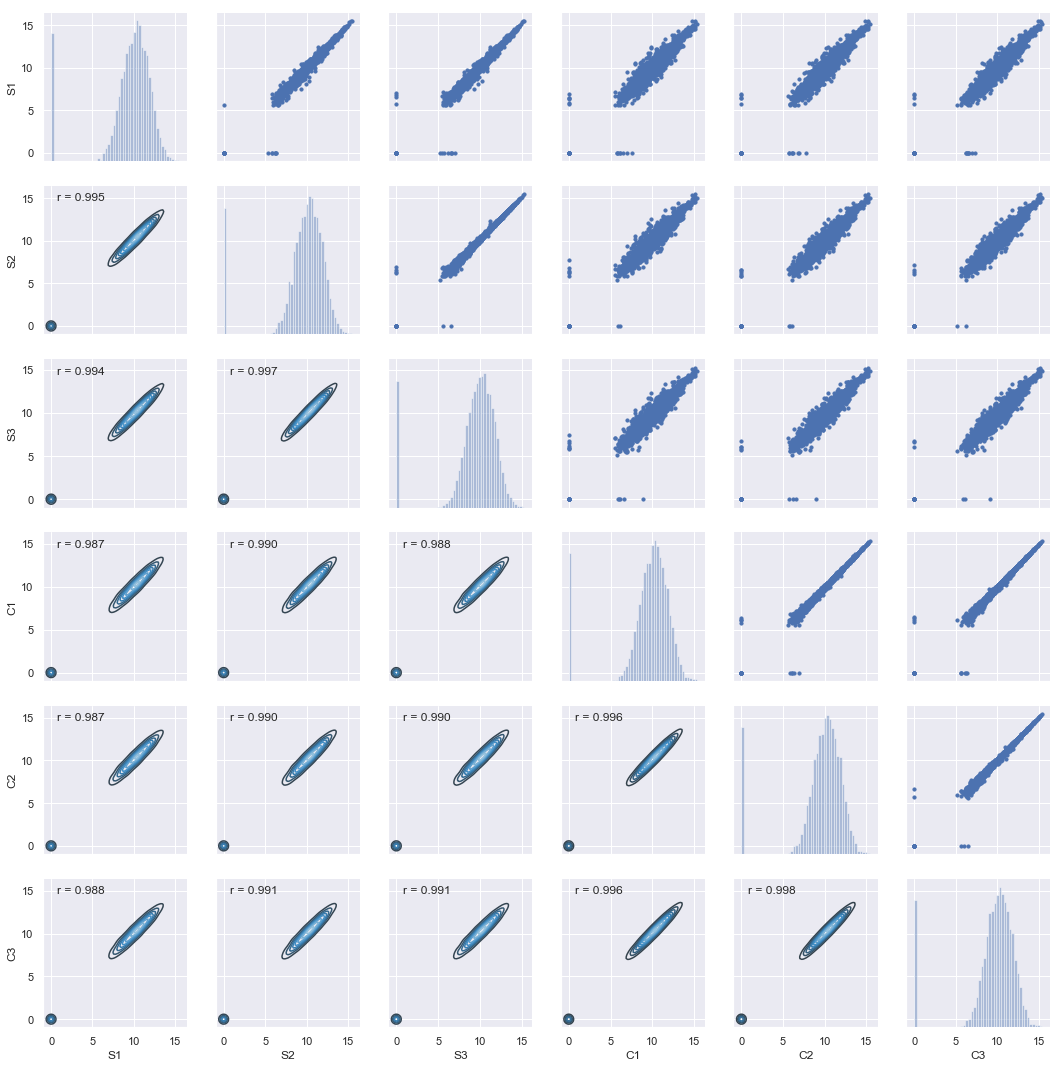

In [86]:
make_scatter_matrix(np.log1p(data))

The figure above show a very good intraclass correlation  between the senescent samples (S1,S2,S3) and the control samples (C1 C2 C3). As expected, the correletion decrese between samples of different classes.

### Data Normalization
We do a correction for sample loading artefact. We do not expect the signal to change much.

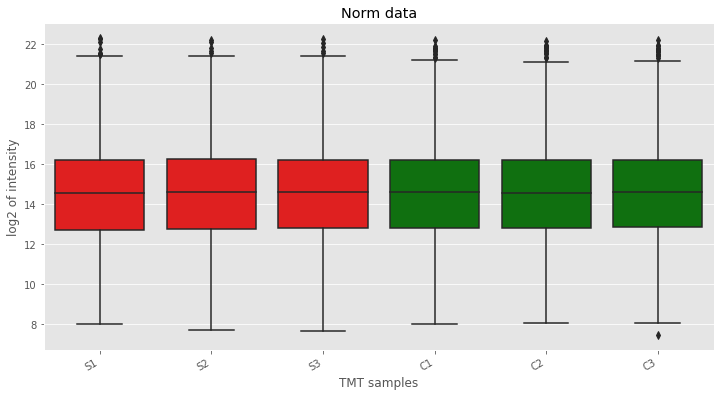

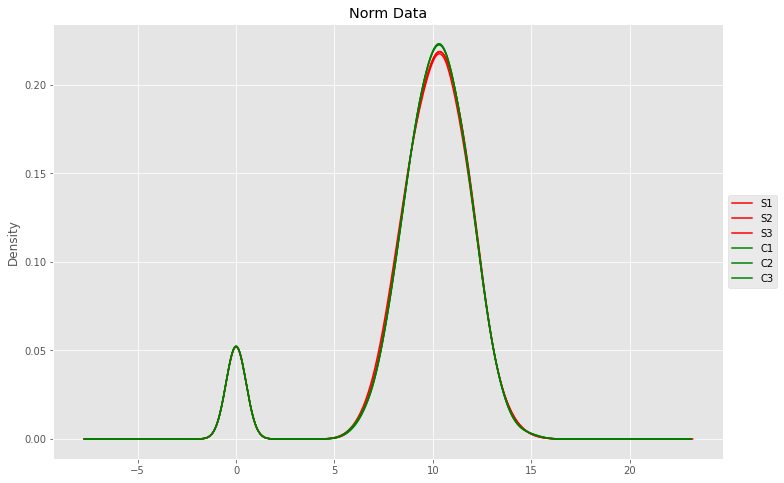

In [12]:
#normalization
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data_norm),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Norm data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data_norm).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm Data')
plt.show()

In [13]:
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.to_csv('norm_data.csv',sep='\t',index=False)

### Testing for differences.
We use limma package in R to identify protein with a differential expression between normal and senescent cells.

In [5]:
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 
limma_data <- read_tsv("norm_data.csv")
accession <- limma_data$'genes'
limma_data = within(limma_data, rm('genes'))
head(limma_data)

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col_double(),
  genes = col_character()
)


S1,S2,S3,C1,C2,C3
2908.326,2781.834,2897.360,2490.464,2267.777,2871.261
8947.522,11803.792,11934.307,12155.487,12957.649,13095.315
218861.410,180857.207,189982.339,185763.791,180966.121,197569.850
64067.748,55454.263,62995.873,52715.528,53645.346,50977.875
25759.703,18520.857,20407.031,18277.439,20291.083,20041.772
3041.495,2987.241,3403.049,17575.351,16819.880,16434.468


In [6]:
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")
design
# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)
contrast


senescent,control
1,0
1,0
1,0
0,1
0,1
0,1


,senescent - control
senescent,1
control,-1


In [7]:
S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)

       senescent - control
Down                  1768
NotSig                2393
Up                    2015

,logFC,AveExpr,t,P.Value,adj.P.Val,B
2600,-2.532442,16.51376,-57.80038,1.827807e-11,1.128853e-07,16.75760
3747,-1.594766,18.93717,-49.90381,5.667830e-11,1.174386e-07,15.86065
3967,-2.867746,17.01348,-48.10802,7.515813e-11,1.174386e-07,15.62518
3939,-1.957706,16.57047,-48.03344,7.606126e-11,1.174386e-07,15.61511
4146,-1.372544,18.53226,-44.36504,1.401997e-10,1.731746e-07,15.08956
3733,-2.260503,15.48645,-42.41547,1.981120e-10,1.998023e-07,14.78389
3542,-1.750308,16.22159,-41.68443,2.264599e-10,1.998023e-07,14.66410
327,-1.262187,17.85181,-38.16104,4.465714e-10,3.267784e-07,14.04317
2479,-1.483720,17.80782,-36.87784,5.808243e-10,3.267784e-07,13.79744
761,2.390311,15.10721,36.79695,5.907063e-10,3.267784e-07,13.78157


In [9]:
limma_data$ave_med <- rowMeans(limma_data[S])
limma_data$ave_exo  <- rowMeans(limma_data[C])
limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          (limma_data$ave_exo / limma_data$ave_med), 
                          (-1 * limma_data$ave_med / limma_data$ave_exo))
limma_data$Acc <- accession
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc
2908.326,2781.834,2897.360,2490.464,2267.777,2871.261,2862.507,2543.167,-0.17065256,-1.125567,0_CLN3
8947.522,11803.792,11934.307,12155.487,12957.649,13095.315,10895.207,12736.150,0.22523562,1.168968,1_SLC35B3
218861.410,180857.207,189982.339,185763.791,180966.121,197569.850,196566.985,188099.921,-0.06352179,-1.045014,2_SERPINB6
64067.748,55454.263,62995.873,52715.528,53645.346,50977.875,60839.294,52446.250,-0.21416380,-1.160031,3_hCG_2014768
25759.703,18520.857,20407.031,18277.439,20291.083,20041.772,21562.530,19536.765,-0.14233490,-1.103690,4_HDGFRP3
3041.495,2987.241,3403.049,17575.351,16819.880,16434.468,3143.928,16943.233,2.43006908,5.389192,5_CRYAB


In [10]:
# statisticl test results
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR
2908.326,2781.834,2897.360,2490.464,2267.777,2871.261,2862.507,2543.167,-0.17065256,-1.125567,0_CLN3,2.159745e-01,2.887139e-01
8947.522,11803.792,11934.307,12155.487,12957.649,13095.315,10895.207,12736.150,0.22523562,1.168968,1_SLC35B3,8.501973e-02,1.318639e-01
218861.410,180857.207,189982.339,185763.791,180966.121,197569.850,196566.985,188099.921,-0.06352179,-1.045014,2_SERPINB6,4.319524e-01,5.146100e-01
64067.748,55454.263,62995.873,52715.528,53645.346,50977.875,60839.294,52446.250,-0.21416380,-1.160031,3_hCG_2014768,1.094410e-02,2.359190e-02
25759.703,18520.857,20407.031,18277.439,20291.083,20041.772,21562.530,19536.765,-0.14233490,-1.103690,4_HDGFRP3,3.119844e-01,3.926667e-01
3041.495,2987.241,3403.049,17575.351,16819.880,16434.468,3143.928,16943.233,2.43006908,5.389192,5_CRYAB,6.308583e-09,6.493634e-07


In [11]:
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [13]:
# count candidates
print("Candidate Counts:")
summary(limma_data$candidate)

[1] "Candidate Counts:"


high  med  low   no NA's 
2366  950  467 2393  438

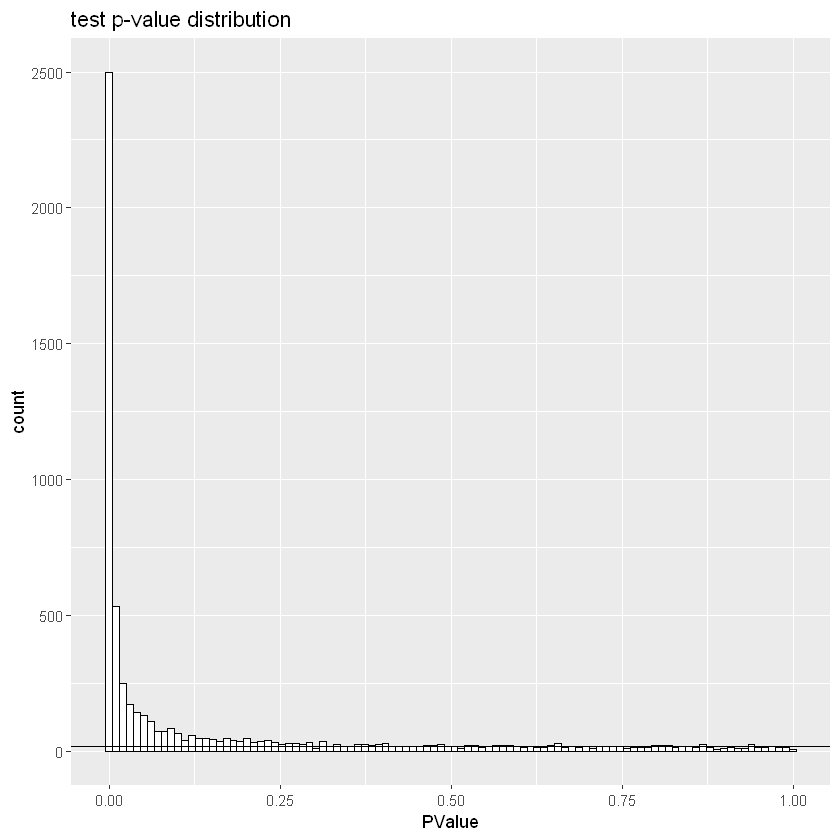

In [16]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

pvalue_plot(limma_data, "test")

The figure above show the expected distribution of p-value, our test is safe

In [14]:
#data_norm = pd.read_csv('norm_data.csv',sep='\t')
print(data_norm.shape)
data_norm.head()
#del data_norm['gene_names']

(6614, 7)


,S1,S2,S3,C1,C2,C3,genes
0,2908.326176,2781.833898,2897.359696,2490.464247,2267.777051,2871.261057,0_CLN3
1,8947.522318,11803.792470,11934.306701,12155.486528,12957.649160,13095.314840,1_SLC35B3
2,218861.409955,180857.206581,189982.338639,185763.791347,180966.121127,197569.849783,2_SERPINB6
3,64067.748167,55454.262627,62995.872526,52715.528300,53645.345935,50977.875348,3_hCG_2014768
4,25759.702591,18520.857245,20407.031028,18277.439217,20291.083091,20041.772111,4_HDGFRP3


In [15]:
#we load back the R analysis
r_analysis = pd.read_table('r_analysis_limma.txt',sep=' ')
print(r_analysis.shape)
r_analysis = r_analysis.reset_index(drop=True)
r_analysis.head()

(6614, 14)


,S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
0,2908.326176,2781.833898,2897.359696,2490.464247,2267.777051,2871.261057,2862.506590,2543.167452,-0.170653,-1.125567,0_CLN3,0.215974,0.288714,no
1,8947.522318,11803.792470,11934.306701,12155.486528,12957.649160,13095.314840,10895.207163,12736.150176,0.225236,1.168968,1_SLC35B3,0.085020,0.131864,no
2,218861.409955,180857.206581,189982.338639,185763.791347,180966.121127,197569.849783,196566.985058,188099.920752,-0.063522,-1.045014,2_SERPINB6,0.431952,0.514610,no
3,64067.748167,55454.262627,62995.872526,52715.528300,53645.345935,50977.875348,60839.294440,52446.249861,-0.214164,-1.160031,3_hCG_2014768,0.010944,0.023592,med
4,25759.702591,18520.857245,20407.031028,18277.439217,20291.083091,20041.772111,21562.530288,19536.764806,-0.142335,-1.103690,4_HDGFRP3,0.311984,0.392667,no


In [16]:
data_def = data_norm.merge(r_analysis.iloc[:,6:],left_on='genes',right_on='Acc' )
data_def.shape

(6614, 15)

In [18]:
#top 50 proteins
data_def.sort_values('FDR').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
2599,3.766010e+04,4.015703e+04,3.892785e+04,2.280259e+05,2.174401e+05,2.299338e+05,2742_HEL-S-117,3.891499e+04,2.251333e+05,2.532381,5.785259,2742_HEL-S-117,1.827807e-11,1.128853e-07,high
3938,4.779559e+04,4.927304e+04,5.112491e+04,1.911426e+05,1.899645e+05,1.943501e+05,4098_SQSTM1,4.939785e+04,1.918191e+05,1.957226,3.883146,4098_SQSTM1,7.606126e-11,1.174386e-07,high
3746,2.822718e+05,2.927576e+05,2.915307e+05,8.877884e+05,8.537236e+05,8.758917e+05,3903_TAGLN,2.888534e+05,8.724679e+05,1.594765,3.020453,3903_TAGLN,5.667830e-11,1.174386e-07,high
3966,5.345572e+04,4.620143e+04,4.754837e+04,3.683171e+05,3.462346e+05,3.581174e+05,4126_NCOA4,4.906851e+04,3.575564e+05,2.865301,7.286881,4126_NCOA4,7.515813e-11,1.174386e-07,high
4145,2.368307e+05,2.388596e+05,2.311788e+05,6.201530e+05,6.052933e+05,6.047763e+05,4305_MYLK,2.356230e+05,6.100742e+05,1.372504,2.589196,4305_MYLK,1.401997e-10,1.731746e-07,high
3732,2.065334e+04,2.200385e+04,2.029794e+04,1.044500e+05,9.967930e+04,9.746864e+04,3889_SCN7A,2.098504e+04,1.005327e+05,2.260231,4.790681,3889_SCN7A,1.981120e-10,1.998023e-07,high
3541,4.112963e+04,4.270039e+04,4.117418e+04,1.434491e+05,1.360874e+05,1.410528e+05,3696_GABARAPL2,4.166807e+04,1.401964e+05,1.750435,3.364601,3696_GABARAPL2,2.264599e-10,1.998023e-07,high
3878,5.585350e+03,5.443103e+03,5.170321e+03,4.139897e+04,3.603304e+04,3.616405e+04,4038_PLA2G7,5.399591e+03,3.786535e+04,2.809956,7.012634,4038_PLA2G7,8.994872e-10,3.267784e-07,high
6142,1.026169e+06,1.037677e+06,1.025947e+06,2.076790e+06,2.010923e+06,2.014649e+06,6345_MYOF,1.029931e+06,2.034121e+06,0.981858,1.975007,6345_MYOF,7.633982e-10,3.267784e-07,high
326,1.548106e+05,1.487445e+05,1.547448e+05,3.682013e+05,3.628933e+05,3.680115e+05,338_FIP1L1,1.527666e+05,3.663687e+05,1.261967,2.398225,338_FIP1L1,4.465714e-10,3.267784e-07,high


The top 20 protein by FDR are all under represented in senescent cell

## Visualize differential expression

In [19]:
data_def['log10p']=-np.log10(data_def['PValue'])

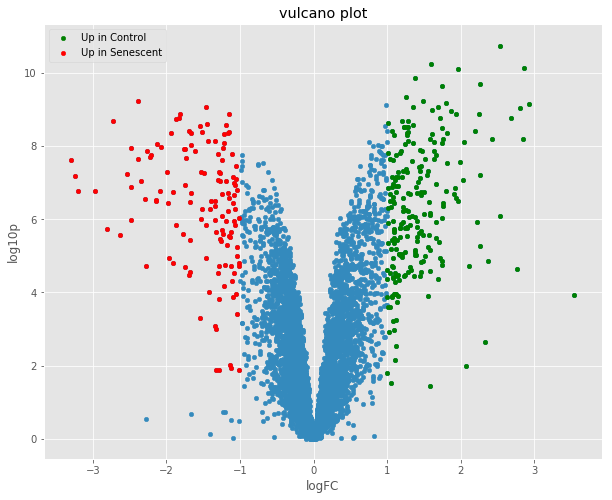

In [20]:
fig,ax=plt.subplots(figsize=(10,8))

data_def.plot(kind='scatter',x='logFC',y='log10p',ax=ax)

data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='g', label='Up in Control')

data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='r', label='Up in Senescent')
plt.legend()
plt.title('vulcano plot')
plt.show()

## Interactive Vulcano Plot


In [27]:
up_control = data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)]
up_senescent = data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)]
the_rest = data_def.iloc[~data_def.index.isin( list(up_control.index.values) + list(up_senescent.index.values) ) ]
#the_rest = the_rest.iloc[~up_senescent.index.values]


In [34]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
#interactive plot 'logFC',y='log10p'
trace_1 = go.Scatter(
    x=the_rest.logFC,
    y=the_rest.log10p,
    mode='markers',
    name='MA Plot',
    #text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    #hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'blue'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_2 = go.Scatter(
    x=up_control.logFC,
    y=up_control.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_3 = go.Scatter(
    x=up_senescent.logFC,
    y=up_senescent.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

'''

annot_1 = go.Scatter(
    x=[temp.signal_perc.loc['Tb927.3.2610']],
    y=[temp.signal_logfc.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)
'''

layout = dict(title='Vulcano',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_1,trace_2,trace_3], 
                layout=layout)
iplot(fig, filename='test')

In [35]:
#attach the old index so we can grab other columns from the MaxQuont ProteinGroup file
data_def['index']=[int(n.split('_')[0]) for n in data_def['genes']]
data_def.head()
data_def.set_index('index',inplace=True,drop=True)

In [40]:
#write proteins for go enrichemnt analysis
#data_def[data_def['logFC']<-1].sort_values('PValue').to_csv('up_senescent.csv')

### Visualize some top candidates


In [38]:
def plot_prot(prot_id = 2742, data_def='', df=''):
    fig,ax = plt.subplots(figsize=(8,8))
    temp = data_def.loc[prot_id][['S1','S2','S3','C1','C2','C3']]
    #print(temp)#
    #print(temp)
    print(df.loc[prot_id]['Protein names'])
    temp.plot(kind='bar', ax=ax, colors=my_pal)
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    plt.show()
data_def[data_def['logFC']<-1].sort_values('PValue').head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
index,,,,,,,,,,,,,,,,
786,83449.682918,84495.354420,74859.798020,14727.001387,15634.545704,15908.933416,786_NAP1L6,80934.945119,15423.493502,-2.391633,-5.247511,786_NAP1L6,5.907063e-10,3.267784e-07,high,9.228628
4290,960809.029804,945548.002237,952902.894500,326023.453615,355044.486628,358880.719308,4290_TGFBI,953086.642180,346649.553184,-1.459129,-2.749424,4290_TGFBI,8.568866e-10,3.267784e-07,high,9.067077
2835,321996.282386,331995.914413,333360.587909,145522.688995,150013.621496,151524.370130,2835_SERPINE2,329117.594903,149020.226874,-1.143095,-2.208543,2835_SERPINE2,1.300861e-09,3.562813e-07,high,8.885769
3423,978326.230309,967086.313191,937524.600726,248720.117053,279043.615390,287811.160702,3423_NAMPT,960979.048075,271858.297715,-1.821650,-3.534853,3423_NAMPT,1.326825e-09,3.562813e-07,high,8.877186
1318,135974.914451,131272.537473,139753.617099,36078.048212,41020.306588,37770.994414,1318_PLAU,135667.023008,38289.783071,-1.825039,-3.543165,1318_PLAU,1.714646e-09,4.072944e-07,high,8.765825


Putative nucleosome assembly protein 1-like 6


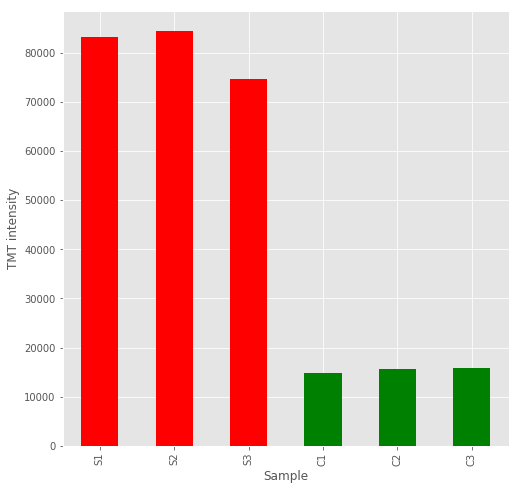

Transforming growth factor-beta-induced protein ig-h3


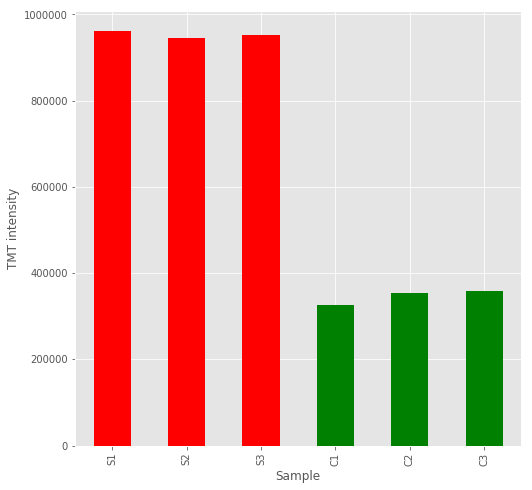

Glia-derived nexin


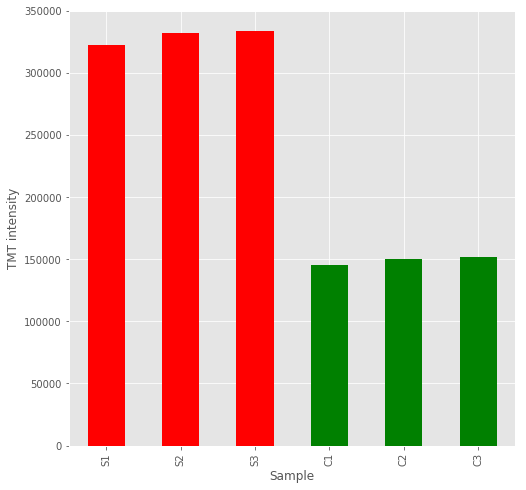

Nicotinamide phosphoribosyltransferase


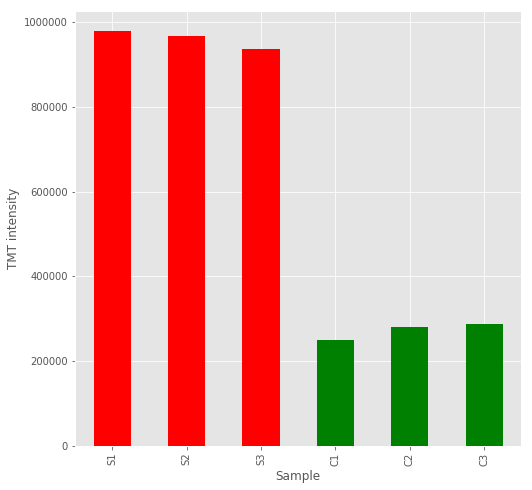

In [39]:
plot_prot(prot_id = 786, data_def=data_def, df=df)  
plot_prot(prot_id = 4290, data_def=data_def, df=df) 
plot_prot(prot_id = 2835, data_def=data_def, df=df) 
plot_prot(prot_id = 3423, data_def=data_def, df=df) 



## Go term analysis
Ae select protein with a log2 fold change greather than 1 between Senescent and control
for go term analysis we will be using david online and visualize the outputs.

Also, if possible, we will select the uniprot-sprot ID between the ids of a protein group as the uniprot-sprot are likely to be better annotated.

In [42]:
def select_id(in_col):
    res = []
    for n in in_col:
        #print(n)
        temp = []
        item_list = n.split(';')
        for acc in item_list:
            #print (acc)
            if acc.count('|') >=2:
                temp_id = acc.split(' ')[0].split('|')[2]
                temp_type = acc.split(' ')[0].split('|')[0]
                #print (temp_type)
                if temp_type == 'sp':
                    temp.append(temp_id)
                    
                    break
        if len(temp) == 0:
            temp_id = item_list[0].split(' ')[0].split('|')[2]
            res.append(temp_id)
        else:
            res.append(temp[0])
    return res
             

df.columns
temp = df[['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
       'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins',
       'Peptides', 'Razor + unique peptides', 'Unique peptides',
       'Peptides PS-TMT', 'Razor + unique peptides PS-TMT',
       'Unique peptides PS-TMT', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths',
        'Q-value','Score']]
temp.head()
selection=data_def.join(temp,how='left')
selection['david_input']=select_id(selection['Fasta headers'])
selection[selection['logFC']<-1].sort_values('FDR').to_csv('up_senescent.csv')

### David Chart
This is an enrichment analysis for all the annotation keywords stored in the david database.
It is the most similar approch to the classical GO-term enrichment analysis. With david database, we have the benefit to test not only the go annotation but also several other controlled vocabulary annotation such as Panther, OMIM disease, uniprot keywords and so on

In [55]:
david_chart = pd.read_table('david\senescent_chart_E5E10F1F9FE11558598909804.txt')
david_chart.columns
genes = david_chart.Genes
del david_chart['Genes']
print(david_chart.shape)
david_chart[['Category','Term','Count','PValue']].head(30)

(277, 12)


,Category,Term,Count,PValue
0,GOTERM_CC_DIRECT,GO:0005615~extracellular space,39,7.795639e-14
1,UP_SEQ_FEATURE,signal peptide,52,6.694226e-10
2,UP_KEYWORDS,Secreted,38,1.178060e-09
3,UP_KEYWORDS,Signal,57,5.046490e-09
4,GOTERM_CC_DIRECT,GO:0005576~extracellular region,35,5.203820e-09
5,UP_KEYWORDS,Glycoprotein,59,1.787282e-08
6,UP_SEQ_FEATURE,disulfide bond,44,7.640002e-08
7,UP_KEYWORDS,Disulfide bond,48,1.087174e-07
8,GOTERM_BP_DIRECT,GO:0006954~inflammatory response,16,1.168337e-07
9,GOTERM_BP_DIRECT,GO:0030198~extracellular matrix organization,12,2.043422e-07


Those are the top 30 enriched terms. Several key words are clearly releted with senescence and re-organization of the extracellular matrix (extracellular space, signal peptide, inflammatory response, Rheumatoid arthritis

### David Cluster
Another peculiarity of david is to create cluster of similar keywords, that get togeter because they are releted to each other.

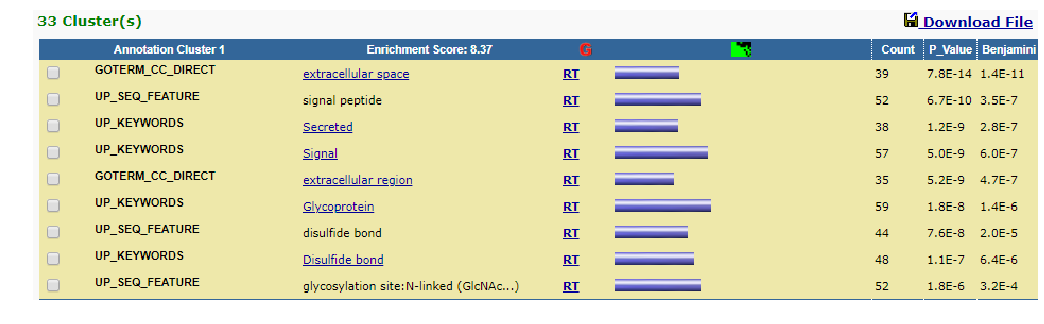

In [76]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread('david/Capture.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

In [ ]:
# we use this cluster to get putative proteins that 

In [83]:
sprot_features = pd.read_table('uniprot_features.txt')

In [82]:
selection = selection.merge(sprot_features, left_on='david_input', right_on='yourlist')
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,yourlist,Entry,Entry name,Protein names_y,Gene names_y,Organism,Length,Transmembrane,Transit peptide,Signal peptide
0,19957.365370,21385.348093,22934.889387,9231.138358,10166.741888,11769.244172,19_PPT2,21425.867617,10389.041473,-1.044291,...,G8JLL2_HUMAN,G8JLL2,G8JLL2_HUMAN,Lysosomal thioesterase PPT2 (Fragment),PPT2,Homo sapiens (Human),180,NaN,NaN,SIGNAL 1 27 {ECO:0000256|SAM:SignalP}.
1,22348.557417,22642.303778,21048.673034,8804.727932,9256.446305,8874.397651,59_FGF2,22013.178076,8978.523963,-1.293817,...,FGF2_HUMAN,P09038,FGF2_HUMAN,Fibroblast growth factor 2 (FGF-2) (Basic fibr...,FGF2 FGFB,Homo sapiens (Human),288,NaN,NaN,NaN
2,41512.939840,44192.015691,38495.001279,19198.468894,13236.551440,20962.681704,76_MYCBP,41399.985603,17799.234013,-1.217815,...,MYCBP_HUMAN,Q99417,MYCBP_HUMAN,c-Myc-binding protein (Associate of Myc 1) (AM...,MYCBP AMY1,Homo sapiens (Human),103,NaN,NaN,NaN
3,13120.948249,11930.153094,11274.013676,1149.023995,2144.249723,1909.150302,96_C11orf96,12108.371673,1734.141340,-2.803711,...,CK096_HUMAN,Q7Z7L8,CK096_HUMAN,Uncharacterized protein C11orf96 (Protein Ag2 ...,C11orf96 AG2,Homo sapiens (Human),435,NaN,NaN,NaN
4,32536.787259,39589.828736,40893.827424,7684.019021,9507.175686,9507.094837,116_SLC16A6,37673.481140,8899.429848,-2.081765,...,MOT7_HUMAN,O15403,MOT7_HUMAN,Monocarboxylate transporter 7 (MCT 7) (Monocar...,SLC16A6 MCT6 MCT7,Homo sapiens (Human),523,TRANSMEM 22 42 Helical. {ECO:0000255}.; TRANSM...,NaN,NaN


## Vulcano Plot with only selected proteins
we add transmembrane regions and signal peptide to add to the legend

In [86]:
selection.to_csv('def.csv')

In [154]:
selection = selection.replace(-np.inf,-4)
selection['log10p']=selection['log10p'].fillna(selection['log10p'].mean())
text_list = []
look_into = []

for n in selection.index.values:
    a=0
    text = selection['Protein names_y'].loc[n]
    text = text.split(' (')[0]
    text+='\n'
    #print (selection['Signal peptide'].loc[n])
    if str(selection['Signal peptide'].loc[n]) != 'nan':
        text+='has signal peptide\n'
        a=1
    if str(selection['Transmembrane'].loc[n]) != 'nan':
        text+='has Transmembrane\n'
        a=1
    if a >0:
        look_into.append(n)
    
    text_list.append(text)   

In [155]:
#interactive plot 'logFC',y='log10p'
trace_2 = go.Scatter(
    x=selection.logFC,
    y=selection.log10p,
    mode='markers',
    name='MA Plot',
    text = text_list,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

layout = dict(title='Vulcano, only selected',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_2], 
                layout=layout)
iplot(fig, filename='test')